# FaceForensics++ C23 – Full Pipeline with YOLO Face Crops

This notebook trains a binary classifier (REAL vs FAKE) on face crops
preprocessed by YOLO (from `processing_detect_n_crop.ipynb`).

**Assumptions**:
- Preprocessed faces are stored under `FFprocessed/` with subfolders:
  - `original/`          → REAL
  - `Deepfakes/`, `FaceSwap/`, `Face2Face/`, `NeuralTextures/`,
    `FaceShifter/`, `DeepFakeDetection/` → FAKE
- Each video corresponds to a folder inside these method folders,
  containing ~20 face images like `frame_000.png`, etc.

This notebook will:
1. Build train/val/test splits at the **video** level.
2. Flatten them into `data_yolo_faces/{train,val,test}/{REAL,FAKE}`.
3. Create PyTorch `ImageFolder` datasets and loaders.
4. Train a ResNet18 classifier and save the best model.
5. Evaluate on the held-out test set.

In [1]:
# 1. Configure dataset paths and environment
from pathlib import Path
import os
import random
import shutil

import numpy as np
import torch

DATA_ROOT = Path("FFprocessed")       # where YOLO face crops live
OUT_ROOT = Path("data_yolo_faces")   # where we will build REAL/FAKE splits

OUT_ROOT.mkdir(exist_ok=True)

RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

print("DATA_ROOT:", DATA_ROOT.resolve())
print("OUT_ROOT:", OUT_ROOT.resolve())

DATA_ROOT: C:\Users\Aqsa\Documents\BINUS SEMSETER 5\DEEPL\FFprocessed
OUT_ROOT: C:\Users\Aqsa\Documents\BINUS SEMSETER 5\DEEPL\data_yolo_faces


In [ ]:
# 2. Build train/val/test splits at VIDEO level from FFprocessed

from collections import defaultdict

# Methods: original = REAL, others = FAKE
REAL_METHOD = "original"
FAKE_METHODS = [
    "Deepfakes",
    "FaceSwap",
    "Face2Face",
    "NeuralTextures",
    "FaceShifter",
    "DeepFakeDetection",
]

video_entries = []  # list of (method, video_id, label, path)

for method in [REAL_METHOD] + FAKE_METHODS:
    method_dir = DATA_ROOT / method
    if not method_dir.exists():
        print(f"Warning: method folder not found: {method_dir}")
        continue

    for video_dir in method_dir.iterdir():
        if not video_dir.is_dir():
            continue
        imgs = [p for p in video_dir.iterdir() if p.is_file()]
        if not imgs:
            continue
        label = "REAL" if method == REAL_METHOD else "FAKE"
        video_entries.append({
            "method": method,
            "video_id": video_dir.name,
            "label": label,
            "path": str(video_dir),
            "num_frames": len(imgs),
        })

print("Total videos found:", len(video_entries))
labels = [e["label"] for e in video_entries]
print("Label counts:", {"REAL": labels.count("REAL"), "FAKE": labels.count("FAKE")})

import numpy as np
from sklearn.model_selection import train_test_split

indices = np.arange(len(video_entries))
labels_np = np.array(labels)

train_idx, temp_idx = train_test_split(
    indices,
    test_size=0.30,
    stratify=labels_np,
    random_state=RANDOM_STATE,
)

val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.50,
    stratify=labels_np[temp_idx],
    random_state=RANDOM_STATE,
)

def subset(entries, idx):
    return [entries[i] for i in idx]

train_videos = subset(video_entries, train_idx)
val_videos = subset(video_entries, val_idx)
test_videos = subset(video_entries, test_idx)

def count_labels(entries):
    c = defaultdict(int)
    for e in entries:
        c[e["label"]] += 1
    return dict(c)

print("Train videos:", len(train_videos), count_labels(train_videos))
print("Val videos:", len(val_videos), count_labels(val_videos))
print("Test videos:", len(test_videos), count_labels(test_videos))

In [ ]:
# 3. Flatten videos into data_yolo_faces/{train,val,test}/{REAL,FAKE} with parallel file copying and tqdm progress bars
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

def copy_image(src, dst):
    if not dst.exists():
        try:
            shutil.copy2(src, dst)
            return True
        except Exception as ex:
            print(f"Copy failed for {src} → {dst}: {ex}")
    return False

def prepare_split(split_name, entries, max_workers=8):
    split_root = OUT_ROOT / split_name
    (split_root / "REAL").mkdir(parents=True, exist_ok=True)
    (split_root / "FAKE").mkdir(parents=True, exist_ok=True)

    num_copied = 0
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for e in tqdm(entries, desc=f"{split_name} videos", unit="video"):
            src_video_dir = Path(e["path"])
            label = e["label"]
            dst_dir = split_root / label

            img_paths = [img_path for img_path in src_video_dir.iterdir() if img_path.is_file()]
            for img_path in tqdm(img_paths, desc=f"{e['video_id']} images", leave=False, unit="img"):
                dst_path = dst_dir / f"{e['method']}_{e['video_id']}_{img_path.name}"
                futures.append(executor.submit(copy_image, img_path, dst_path))

        for f in tqdm(as_completed(futures), total=len(futures), desc="Copying images", unit="img"):
            if f.result():
                num_copied += 1

    print(f"Prepared split {split_name}: {num_copied} images")

prepare_split("train", train_videos)
prepare_split("val", val_videos)
prepare_split("test", test_videos)

In [2]:
# Read train/val/test splits directly from split directories (no re-splitting, files only)

from collections import defaultdict

def get_split_entries(split_name):
    split_root = OUT_ROOT / split_name
    entries = []
    for label in ["REAL", "FAKE"]:
        label_dir = split_root / label
        if not label_dir.exists():
            print(f"Warning: label folder not found: {label_dir}")
            continue
        for item in label_dir.iterdir():
            # Only add if it's a file (not a directory)
            if item.is_file():
                entries.append({
                    "label": label,
                    "path": str(item.resolve()),
                    "filename": item.name,
                })
    return entries

train_videos = get_split_entries("train")
val_videos = get_split_entries("val")
test_videos = get_split_entries("test")

def count_labels(entries):
    c = defaultdict(int)
    for e in entries:
        c[e["label"]] += 1
    return dict(c)

print("Train images:", len(train_videos), count_labels(train_videos))
print("Val images:", len(val_videos), count_labels(val_videos))
print("Test images:", len(test_videos), count_labels(test_videos))

Train images: 97156 {'REAL': 13843, 'FAKE': 83313}
Val images: 20759 {'REAL': 2970, 'FAKE': 17789}
Test images: 20784 {'REAL': 2960, 'FAKE': 17824}


In [3]:
# 4. ImageFolder datasets and DataLoaders for data_yolo_faces

from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

faces_dir = OUT_ROOT  # data_yolo_faces

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.08),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

eval_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

train_dataset = datasets.ImageFolder(root=str(faces_dir / "train"), transform=train_transform)
val_dataset = datasets.ImageFolder(root=str(faces_dir / "val"), transform=eval_transform)
test_dataset = datasets.ImageFolder(root=str(faces_dir / "test"), transform=eval_transform)

print("Classes:", train_dataset.classes)
print("Train images:", len(train_dataset))
print("Val images:", len(val_dataset))
print("Test images:", len(test_dataset))

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

len(train_loader), len(val_loader), len(test_loader)

Using device: cuda
Classes: ['FAKE', 'REAL']
Train images: 97156
Val images: 20759
Test images: 20784


(1519, 325, 325)

In [4]:
# 5. Define ResNet18 model, loss, optimizer with class weights for imbalance
import torch.nn as nn
from collections import Counter
import numpy as np

def create_model(num_classes=2, use_pretrained=True):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if use_pretrained else None)
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features, num_classes),
    )
    return model

model = create_model(num_classes=2, use_pretrained=True).to(device)

# Compute class weights from training set
targets = [label for _, label in train_dataset.samples]
class_counts = Counter(targets)
num_classes = len(train_dataset.classes)
total = sum(class_counts.values())
class_weights = [total / (num_classes * class_counts[i]) for i in range(num_classes)]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
print(f"Class weights: {class_weights}")

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=1)

print(model.fc)

Class weights: [0.5830782710981479, 3.5092104312648993]
Sequential(
  (0): Dropout(p=0.3, inplace=False)
  (1): Linear(in_features=512, out_features=2, bias=True)
)


In [5]:
# 6. Training and validation loop with tqdm progress bars

import time
from tqdm import tqdm

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    for inputs, labels in tqdm(loader, desc="Training", unit="batch"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels).item()
        total += inputs.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total
    return epoch_loss, epoch_acc

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    for inputs, labels in tqdm(loader, desc="Validation", unit="batch"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels).item()
        total += inputs.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total
    return epoch_loss, epoch_acc

num_epochs = 20
best_val_acc = 0.0
best_state_dict = None

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(num_epochs):
    start_time = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    elapsed = time.time() - start_time

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    scheduler.step(val_loss)

    print(
        f"Epoch {epoch+1}/{num_epochs} | ",
        f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, ",
        f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}, ",
        f"time={elapsed:.1f}s"
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state_dict = model.state_dict()

print("Best val acc:", best_val_acc)

if best_state_dict is not None:
    model.load_state_dict(best_state_dict)
    torch.save(model.state_dict(), "best_resnet_ffpp_yolo_faces.pth")
    print("Saved best model to best_resnet_ffpp_yolo_faces.pth")

Validation: 100%|██████████| 325/325 [00:54<00:00,  5.98batch/s]


Epoch 1/20 |  train_loss=0.4387, train_acc=0.7806,  val_loss=0.2990, val_acc=0.8636,  time=428.7s


Validation: 100%|██████████| 325/325 [00:52<00:00,  6.18batch/s]


Epoch 2/20 |  train_loss=0.2673, train_acc=0.8742,  val_loss=0.2485, val_acc=0.8960,  time=424.2s


Validation: 100%|██████████| 325/325 [00:53<00:00,  6.12batch/s]


Epoch 3/20 |  train_loss=0.2139, train_acc=0.9022,  val_loss=0.2260, val_acc=0.9061,  time=425.5s


Validation: 100%|██████████| 325/325 [00:59<00:00,  5.45batch/s]


Epoch 4/20 |  train_loss=0.1850, train_acc=0.9144,  val_loss=0.2931, val_acc=0.8850,  time=432.7s


Validation: 100%|██████████| 325/325 [00:53<00:00,  6.05batch/s]


Epoch 5/20 |  train_loss=0.1694, train_acc=0.9238,  val_loss=0.3068, val_acc=0.8769,  time=434.9s


Validation: 100%|██████████| 325/325 [00:54<00:00,  5.97batch/s]


Epoch 6/20 |  train_loss=0.1185, train_acc=0.9439,  val_loss=0.2607, val_acc=0.9025,  time=428.5s


Validation: 100%|██████████| 325/325 [00:53<00:00,  6.02batch/s]


Epoch 7/20 |  train_loss=0.1105, train_acc=0.9476,  val_loss=0.2671, val_acc=0.8991,  time=426.3s


Validation: 100%|██████████| 325/325 [00:53<00:00,  6.09batch/s]


Epoch 8/20 |  train_loss=0.0879, train_acc=0.9569,  val_loss=0.2726, val_acc=0.9029,  time=424.5s


Validation: 100%|██████████| 325/325 [00:53<00:00,  6.07batch/s]


Epoch 9/20 |  train_loss=0.0813, train_acc=0.9586,  val_loss=0.2350, val_acc=0.9138,  time=426.6s


Validation: 100%|██████████| 325/325 [00:54<00:00,  6.01batch/s]


Epoch 10/20 |  train_loss=0.0706, train_acc=0.9648,  val_loss=0.2629, val_acc=0.9127,  time=428.0s


Validation: 100%|██████████| 325/325 [00:54<00:00,  6.00batch/s]


Epoch 11/20 |  train_loss=0.0684, train_acc=0.9657,  val_loss=0.2805, val_acc=0.9094,  time=426.7s


Validation: 100%|██████████| 325/325 [00:54<00:00,  5.95batch/s]


Epoch 12/20 |  train_loss=0.0632, train_acc=0.9669,  val_loss=0.2839, val_acc=0.9126,  time=428.4s


Validation: 100%|██████████| 325/325 [00:54<00:00,  5.97batch/s]


Epoch 13/20 |  train_loss=0.0621, train_acc=0.9675,  val_loss=0.2861, val_acc=0.9121,  time=429.1s


Validation: 100%|██████████| 325/325 [01:03<00:00,  5.11batch/s]


Epoch 14/20 |  train_loss=0.0580, train_acc=0.9693,  val_loss=0.2908, val_acc=0.9129,  time=464.0s


Validation: 100%|██████████| 325/325 [01:00<00:00,  5.36batch/s]


Epoch 15/20 |  train_loss=0.0563, train_acc=0.9706,  val_loss=0.2892, val_acc=0.9143,  time=502.6s


Validation: 100%|██████████| 325/325 [01:03<00:00,  5.09batch/s]


Epoch 16/20 |  train_loss=0.0560, train_acc=0.9708,  val_loss=0.2989, val_acc=0.9121,  time=500.8s


Validation: 100%|██████████| 325/325 [00:54<00:00,  5.95batch/s]


Epoch 17/20 |  train_loss=0.0552, train_acc=0.9706,  val_loss=0.3028, val_acc=0.9112,  time=473.0s


Validation: 100%|██████████| 325/325 [01:07<00:00,  4.84batch/s]


Epoch 18/20 |  train_loss=0.0541, train_acc=0.9712,  val_loss=0.2789, val_acc=0.9137,  time=531.2s


Validation: 100%|██████████| 325/325 [01:09<00:00,  4.71batch/s]


Epoch 19/20 |  train_loss=0.0538, train_acc=0.9708,  val_loss=0.3023, val_acc=0.9124,  time=526.7s


Validation: 100%|██████████| 325/325 [01:03<00:00,  5.13batch/s]

Epoch 20/20 |  train_loss=0.0548, train_acc=0.9710,  val_loss=0.3071, val_acc=0.9128,  time=501.9s
Best val acc: 0.914302230357917
Saved best model to best_resnet_ffpp_yolo_faces.pth


Test accuracy (YOLO faces): 0.913154349499615


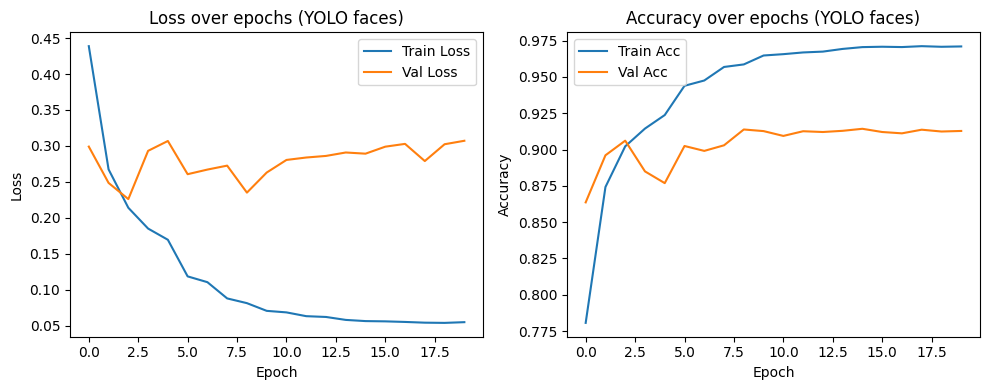

Confusion Matrix (rows=true, cols=pred):
[[16819  1005]
 [  800  2160]]

Classification Report:
              precision    recall  f1-score   support

        FAKE     0.9546    0.9436    0.9491     17824
        REAL     0.6825    0.7297    0.7053      2960

    accuracy                         0.9132     20784
   macro avg     0.8185    0.8367    0.8272     20784
weighted avg     0.9158    0.9132    0.9144     20784



In [6]:
# 7. Test evaluation and plots

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

@torch.no_grad()
def evaluate_simple(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()
        total += inputs.size(0)
    return correct / total if total > 0 else 0.0

test_acc = evaluate_simple(model, test_loader, device)
print("Test accuracy (YOLO faces):", test_acc)

# Plot training and validation loss/accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over epochs (YOLO faces)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over epochs (YOLO faces)")
plt.legend()

plt.tight_layout()
plt.show()

@torch.no_grad()
def get_predictions_and_labels(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_preds, all_labels

y_pred, y_true = get_predictions_and_labels(model, test_loader, device)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix (rows=true, cols=pred):")
print(cm)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes, digits=4))